Part 1

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(0)

γ = 2.
β = 0.95
T = 300
x0 = 10.
Rf = 1.0104  # Updated to match the given 1.04% gross return

batch_size = 64

def u(c):
    return c**(1 - γ) / (1 - γ)

def c(theta_c, x):
    return jax.nn.sigmoid(theta_c) * x

def alpha(theta_alpha, x):
    return jax.nn.sigmoid(theta_alpha)

def stock_return(rng):
    μs = 0.06
    σs = 0.2
    ε = jax.random.normal(rng, ())
    log_return = μs + σs * ε
    return jnp.exp(log_return)

def L(theta, rng, batch_size):
    theta_c, theta_alpha = theta

    def one_simulation(rng):
        rng_t = jax.random.split(rng, T)
        x = x0
        V = 0.

        carry = x, V
        inputs = jnp.arange(300), rng_t

        def core(carry, inputs):
            x, V = carry
            t, rng = inputs
            ct = c(theta_c, x)
            α = alpha(theta_alpha, x)
            cx = ct / x
            ut = u(ct)

            V = V + ut * β**t
            R = stock_return(rng)
            st = (x - ct)
            x = st * (R * α + (1 - α) * Rf)

            return (x, V), (cx, α)

        (x, V), (ct, alphas) = jax.lax.scan(core, carry, inputs)
        return V, ct, alphas

    rng_s = jax.random.split(rng, batch_size)
    V, ct, alphas = jax.vmap(one_simulation)(rng_s)
    return -V.mean(), (ct.mean(0), alphas.mean(0))

import optax
optimizer = optax.adam(1e-2)

def sigmoid_inverse(x):
    return jnp.log(x / (1 - x))

theta_c = sigmoid_inverse(0.05)
theta_alpha = sigmoid_inverse(0.2)
theta = (theta_c, theta_alpha)
opt_state = optimizer.init(theta)


@jax.jit
def update(theta, opt_state, rng):
    rng = jax.random.split(rng)[0]
    loss_value, grads = jax.value_and_grad(L, has_aux=True)(theta, rng, batch_size)
    updates, opt_state = optimizer.update(grads, opt_state)
    theta = optax.apply_updates(theta, updates)
    return theta, opt_state, rng, loss_value

# Training loop
for iteration in range(10000):
    theta, opt_state, rng, (loss, _) = update(theta, opt_state, rng)
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}, Average Utility: {-loss:.4f}")

# Final evaluation
rng = jax.random.PRNGKey(1)  # New seed for final evaluation
loss, (cx, alphas) = L(theta, rng, batch_size=1000000)

print(f"\nFinal Results:")
print(f"Average sum of discounted rewards: {-loss:.4f}")




Iteration 0, Average Utility: -86.8515
Iteration 1000, Average Utility: -49.7754
Iteration 2000, Average Utility: -57.2864
Iteration 3000, Average Utility: -52.1797
Iteration 4000, Average Utility: -48.4694
Iteration 5000, Average Utility: -42.9232
Iteration 6000, Average Utility: -59.9634
Iteration 7000, Average Utility: -48.6159
Iteration 8000, Average Utility: -47.5305
Iteration 9000, Average Utility: -41.2002

Final Results:
Average sum of discounted rewards: -49.5430


Part 2

Iteration 0, Loss: 115.3164
Iteration 100, Loss: 58.4170
Iteration 200, Loss: 43.8732
Iteration 300, Loss: 41.4478
Iteration 400, Loss: 41.2625
Iteration 500, Loss: 41.4163
Iteration 600, Loss: 41.3194
Iteration 700, Loss: 41.4282
Iteration 800, Loss: 41.2850
Iteration 900, Loss: 41.3107


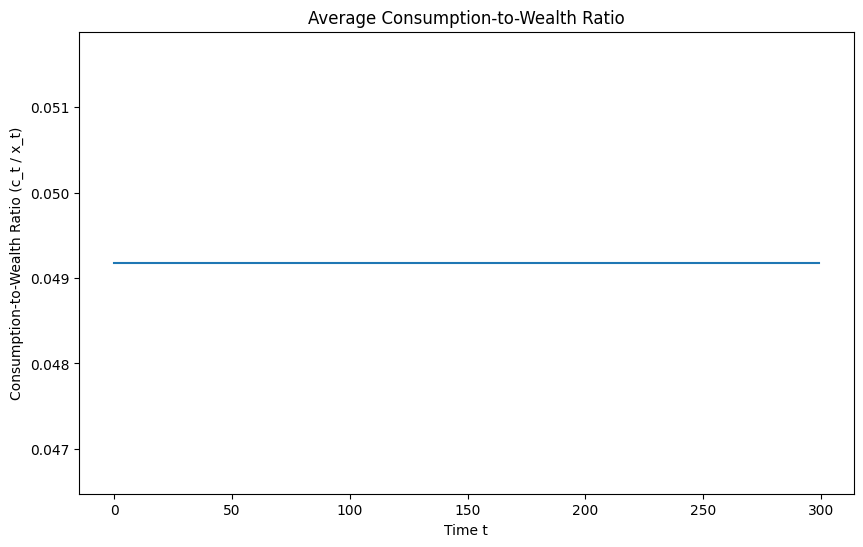

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax

# Initialization
rng = jax.random.PRNGKey(0)
γ = 2.0
β = 0.95
T = 300
x0 = 10.0
Rf = 1.04  # Risk-free rate
batch_size = 100000

# Utility function
def u(c):
    return c**(1 - γ) / (1 - γ)

# Consumption function
def c(theta, x):
    return jax.nn.sigmoid(theta) * x

# Return function
def stock_return(rng):
    μs = 0.06
    σs = 0.2
    ε = jax.random.normal(rng, ())
    log_return = μs + σs * ε
    return jnp.exp(log_return)

# Loss function (returns only the scalar loss for training)
def L_scalar(theta, rng, batch_size):
    def one_simulation(rng):
        rng_t = jax.random.split(rng, T)
        x = x0
        V = 0.0

        carry = x, V
        inputs = jnp.arange(T), rng_t

        def core(carry, inputs):
            x, V = carry
            t, rng = inputs
            ct = c(theta, x)
            ut = u(ct)

            # Discounted utility
            V = V + ut * β**t

            # Update wealth
            R = stock_return(rng)
            st = x - ct
            x = st * R * 0.5 + st * Rf * 0.5  # Split between risky and risk-free assets

            return (x, V), None

        (x, V), _ = jax.lax.scan(core, carry, inputs)
        return V

    rng_s = jax.random.split(rng, batch_size)
    V = jax.vmap(one_simulation)(rng_s)
    return -V.mean()

# Full loss function for final evaluation (returns additional information)
def L_full(theta, rng, batch_size):
    def one_simulation(rng):
        rng_t = jax.random.split(rng, T)
        x = x0
        V = 0.0

        carry = x, V
        inputs = jnp.arange(T), rng_t

        def core(carry, inputs):
            x, V = carry
            t, rng = inputs
            ct = c(theta, x)
            cx = ct / x  # Consumption-to-wealth ratio
            ut = u(ct)

            # Discounted utility
            V = V + ut * β**t

            # Update wealth
            R = stock_return(rng)
            st = x - ct
            x = st * R * 0.5 + st * Rf * 0.5

            return (x, V), cx

        (x, V), cx = jax.lax.scan(core, carry, inputs)
        return V, cx

    rng_s = jax.random.split(rng, batch_size)
    V, cx = jax.vmap(one_simulation)(rng_s)
    return -V.mean(), cx.mean(0)

# Optimizer setup
optimizer = optax.adam(1e-2)

# Inverse function of Sigmoid
def sigmoid_inverse(x):
    return jnp.log(x / (1 - x))

# Initialize parameters
theta = sigmoid_inverse(0.01)
opt_state = optimizer.init(theta)

# Update function
@jax.jit
def update(theta, opt_state, rng):
    rng = jax.random.split(rng)[0]
    loss_value, grads = jax.value_and_grad(L_scalar)(theta, rng, batch_size)
    updates, opt_state = optimizer.update(grads, opt_state)
    theta = optax.apply_updates(theta, updates)
    return theta, opt_state, rng, loss_value

# Training loop
for iteration in range(1000):
    theta, opt_state, rng, loss = update(theta, opt_state, rng)
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss:.4f}")

# Final evaluation
rng = jax.random.PRNGKey(1)
loss, cx = L_full(theta, rng, batch_size)

# Plot consumption-to-wealth ratio over time
plt.figure(figsize=(10, 6))
plt.plot(jnp.arange(300), cx)
plt.title('Average Consumption-to-Wealth Ratio')
plt.xlabel('Time t')
plt.ylabel('Consumption-to-Wealth Ratio (c_t / x_t)')
plt.show()


Part 3

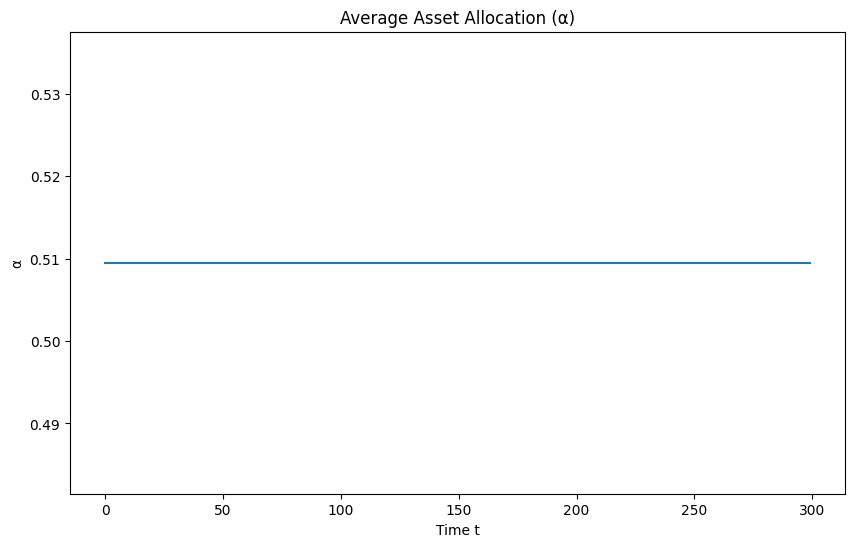

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

#Indexes initialization
rng = jax.random.PRNGKey(0)
γ = 2.
β = 0.95
T = 300
x0 = 10.
Rf = 1.04 #risk-free rate
batch_size = 100000  #1 million simulations

#utility function
def u(c):
    return c**(1 - γ) / (1 - γ)

#cosumption function
def c(theta, x):
    return jax.nn.sigmoid(theta) * x

#return function
def stock_return(rng):
    μs = 0.06
    σs = 0.2
    ε = jax.random.normal(rng, ())
    log_return = μs + σs * ε
    return jnp.exp(log_return)

# Update loss function, α
def L(theta, alpha, rng, batch_size):
    def one_simulation(rng):
        rng_t = jax.random.split(rng, T)
        x = x0
        V = 0.

        carry = x, V
        inputs = jnp.arange(T), rng_t

        def core(carry, inputs):
            x, V = carry
            t, rng = inputs
            ct = c(theta, x)
            α_t = jax.nn.sigmoid(alpha)  # insure α在 in (0,1)
            cx = ct / x
            ut = u(ct)

            # discount utility
            V = V + ut * β**t

            # Proportion α invested in risky assets, the rest in risk-free assets
            R = stock_return(rng)
            st = (x - ct)
            x = st * (R * α_t + (1 - α_t) * Rf)

            return (x, V), (cx,α_t)

        (x, V), (ct,α_t) = jax.lax.scan(core, carry, inputs)
        return V, (ct,α_t)

    rng_s = jax.random.split(rng, batch_size)
    V, (ct,α_t) = jax.vmap(one_simulation)(rng_s)
    return V.mean(), (ct.mean(0), α_t.mean(0))

# Optimizer
import optax
optimizer = optax.adam(-1e-2)

# Inverse function of Sigmoid
def sigmoid_inverse(x):
    return jnp.log(x / (1 - x))

# Initialize theta, alpha
theta = sigmoid_inverse(0.01)
alpha = sigmoid_inverse(0.5)
opt_state_theta = optimizer.init(theta)
opt_state_alpha = optimizer.init(alpha)

# Update function
@jax.jit
def update(theta, alpha, opt_state_theta, opt_state_alpha, rng):
    rng = jax.random.split(rng)[0]

    grads, _ = jax.grad(L, argnums=(0, 1), has_aux=True)(theta, alpha, rng, batch_size)
    grad_theta, grad_alpha = grads  #Unpack from a tuple

    # Check if you need to convert a scalar to an array
    # grad_theta = jnp.array(grad_theta) if jnp.isscalar(grad_theta) else grad_theta
    # grad_alpha = jnp.array(grad_alpha) if jnp.isscalar(grad_alpha) else grad_alpha

    # Update parameters using optax
    updates_theta, opt_state_theta = optimizer.update(grad_theta, opt_state_theta)
    updates_alpha, opt_state_alpha = optimizer.update(grad_alpha, opt_state_alpha)

    theta = optax.apply_updates(theta, updates_theta)
    alpha = optax.apply_updates(alpha, updates_alpha)

    return theta, alpha, opt_state_theta, opt_state_alpha, rng

for iteration in range(1000):
    theta, alpha, opt_state_theta, opt_state_alpha, rng = update(theta, alpha, opt_state_theta, opt_state_alpha, rng)


rng = jax.random.PRNGKey(0)
V, (cx, αx) = L(theta, alpha, rng, batch_size=100000)

plt.figure(figsize=(10, 6))
plt.plot(jnp.arange(300), αx)
plt.title('Average Asset Allocation (α)')
plt.xlabel('Time t')
plt.ylabel('α')
plt.show()